In [1]:
#v3.classification
#28/11/2018

dataname="bladderTE"
ignore_index = -1 #Unet has the possibility of masking out pixels in the output image, we can specify the index value here (though not used)
gpuid=0

desired_mask_mpp = 4 # what we would like to use for finding valid regions of the mask
model_mpp = 1 # MPP of patches to be fed into model
test_fraction = .2

positive_class = 'other'
negative_class = 'green'

use_amp = False

# --- unet params
#these parameters get fed directly into the UNET class, and more description of them can be discovered there
n_classes= 2    #number of classes in the data mask that we'll aim to predict
in_channels= 3  #input channel of the data, RGB = 3
padding= True   #should levels be padded
depth= 4       #depth of the network 
wf= 3           #wf (int): number of filters in the first layer is 2**wf, was 6
up_mode= 'upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

# --- training params
batch_size=3
patch_size=512
stride_size = patch_size
num_epochs = 500
edge_weight = 1 #edges tend to be the most poorly segmented given how little area they occupy in the training set, this paramter boosts their values along the lines of the original UNET paper
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import DenseNet, ResNet, SqueezeNet

import torchvision.models as models

import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

from tensorboardX import SummaryWriter

import scipy.ndimage 

import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix
from sklearn import model_selection

from tqdm.autonotebook import tqdm
from unet import UNet

import os
    
#os.environ['PATH'] = 'C:\\research\\openslide\\bin' + ';' + os.environ['PATH'] #can either specify openslide bin path in PATH, or add it dynamically
import openslide
sys.path.insert(1,'/mnt/data/home/pjl54/WSI_handling')
import wsi

import albumentations as albu
from albumentations.pytorch import ToTensor

from apex import amp

/usr/local/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [4]:
#specify if we should use a GPU (cuda) or only the CPU
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='TITAN X (Pascal)', major=6, minor=1, total_memory=12189MB, multi_processor_count=28)


In [5]:
#build the model according to the paramters specified above and copy it to the GPU. finally print out the number of trainable parameters
 
# model = DenseNet(growth_rate=growth_rate, block_config=block_config,
#                  num_init_features=num_init_features, 
#                  bn_size=bn_size, 
#                  drop_rate=drop_rate, 
#                  num_classes=num_classes).to(device)


#model =  models.mobilenet_v2(pretrained=True).to(device)

model = UNet(n_classes=n_classes, in_channels=in_channels, padding=padding,depth=depth,wf=wf, up_mode=up_mode, batch_norm=batch_norm).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")
#model.classifier=nn.Sequential( nn.Dropout(.2), nn.Linear(1280, num_classes))

# model = models.resnet50(pretrained=False)
# model.fc = nn.Linear(2048,num_classes,bias=True)
# model = model.to(device)


#model = DenseNet(growth_rate=32, block_config=(6, 12, 24, 16), #these represent the default parameters
#                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=3)

total params: 	121538


In [6]:
model

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 3

In [7]:
def check_for_classes(img_fname):
    xml_fname = os.path.splitext(img_fname)[0]+'.xml'
    if(os.path.exists(xml_fname)):
        w = wsi.wsi(None, xml_fname = os.path.splitext(img_fname)[0]+'.xml')
        points, map_idx = w.get_points(colors_to_use=None)
        return len(np.unique(map_idx))>1
    else:
        return False

In [8]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self,files ,transforms=None,edge_weight=1):        
        self.osis=[wsi.wsi(img_fname = file, xml_fname = os.path.splitext(file)[0]+'.xml') for file in tqdm(files) if os.path.exists(os.path.splitext(file)[0]+'.xml')]        
                
        self.transforms = transforms
        self.edge_weight = edge_weight
        self.rscs = [[] for i in range(0,len(self.osis))]
        
        for index, wsi_img in enumerate(self.osis):
            
            stride_size_converted = wsi_img.get_coord_at_mpp(stride_size,input_mpp=wsi_img["mpps"][0],output_mpp=desired_mask_mpp)
            
            [mask_small, resize_factor] = wsi_img.mask_out_annotation(desired_mpp=desired_mask_mpp,colors_to_use=(negative_class,positive_class))            
            
            mask_small = mask_small[list(range(0,np.shape(mask_small)[0],stride_size_converted)),:]            
            mask_small = mask_small[:,list(range(0,np.shape(mask_small)[1],stride_size_converted))]            
            
            [rs,cs]=(mask_small>0).nonzero()
            rs = [r*stride_size_converted for r in rs]
            cs = [c*stride_size_converted for c in cs]
            
            rs = [wsi_img.get_coord_at_mpp(r,wsi_img["mpps"][0],desired_mask_mpp) for r in rs]
            cs = [wsi_img.get_coord_at_mpp(c,wsi_img["mpps"][0],desired_mask_mpp) for c in cs]
            
            goods = np.ones(np.shape(rs)[0])
            for k in range(0,np.shape(rs)[0]):
                
                a = wsi_img.get_tile(coords=(cs[k],rs[k]),wh=(1,1),desired_mpp=desired_mask_mpp)
                if(np.all(a>220)):
                    goods[k] = False             
            
            self.rscs[index]=(cs,rs)            
            
        patch_counts = [np.shape(k)[1] for k in self.rscs]        
        adds = [0] + patch_counts
        adds = np.cumsum(adds)
        self.imgs = np.ones([sum(patch_counts),patch_size,patch_size,3],dtype=np.uint8)
        self.masks = np.ones([sum(patch_counts),patch_size,patch_size],dtype=np.uint8)
            
        for index, wsi_img in enumerate(self.osis):
            for rcidx in range(0,patch_counts[index]-1):

                mask = wsi_img.mask_out_tile(desired_mpp=model_mpp,coords=(self.rscs[index][0][rcidx],self.rscs[index][1][rcidx]),wh=(patch_size,patch_size),colors_to_use=(positive_class,negative_class))                
                img = wsi_img.get_tile(desired_mpp=model_mpp,coords=(self.rscs[index][0][rcidx],self.rscs[index][1][rcidx]),wh=(patch_size,patch_size))        
                
                mask[mask==2] = 1
                mask[mask==6] = 2
                mask = mask - 1
                mask[mask==255] = 0

                self.imgs[rcidx + adds[index],:,:,:] = img
                self.masks[rcidx + adds[index],:,:] = mask
            
            
        self.nitems=len(self.imgs)
        
    def __getitem__(self, index):
        
        img = self.imgs[index,:,:,:]
        mask = self.masks[index,:,:]
        
        
#         tic = time.time()
        totals=np.zeros((2,n_classes)) # we can to keep counts of all the classes in for in particular training, since we 
        totals[0,:]=[0,1]               # can later use this information to create better weights            
        for i,key in enumerate([0,1]): #sum the number of pixels, this is done pre-resize, the but proportions don't change which is really what we're after
            totals[1,i]+=sum(sum(mask==key))
            
        #the original Unet paper assignes increased weights to the edges of the annotated objects
        #their method is more sophistocated, but this one is faster, we simply dilate the mask and 
        #highlight all the pixels which were "added"
        if(self.edge_weight):
            weight = scipy.ndimage.morphology.binary_dilation(mask==1, iterations =2) & ~(mask)
        else: #otherwise the edge weight is all ones and thus has no affect
            weight = np.ones(mask.shape,dtype=mask.dtype)
        
        
        img_new = img
        mask_new = mask
        weight_new = weight.astype(np.uint8)
        seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the transofrmations
        if self.transforms:
            augmented = self.transforms(image=img, masks=[mask,weight])
            img_new = augmented['image']
            mask_new,weight_new = augmented['masks']
                
        return img_new, mask_new, weight_new, totals
    
    def __len__(self):
        return self.nitems

In [9]:
files=glob.glob(r'/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/*.tif')
files = [fname for fname in files if check_for_classes(fname)]
print(files)
# files=glob.glob(r'/mnt/ccipd_data/UPenn_Prostate_Histology/Progressor_nonProgressorProstate/histologyImages/UPenn/*.svs')

['/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/Blad_58.tif', '/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/Blad_40.tif', '/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/Blad_10.tif', '/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/Blad_1.tif', '/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/Blad_20.tif', '/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/Blad_60.tif', '/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/Blad_47.tif', '/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/Blad_69.tif', '/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/Blad_29.tif', '/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/Blad_50.tif', '/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/Blad_34.tif', '/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/Blad_72.tif']


In [10]:
# get name of image with no mask extension
#bases=list(set([os.path.basename(f).replace("_training_mask.tif","") for f in files]))

In [11]:
#create training and validation stages and split the files appropriately between them
phases={}
phases["train"],phases["val"]=next(iter(model_selection.ShuffleSplit(n_splits=1,test_size=test_fraction).split(files)))

In [12]:
for phase in phases.keys(): #now for each of the phases, we'll loop through the files
    #phases[phase]=[f for f in files for b in phases[phase] if bases[b] in f  ]
    phases[phase]=[f for f in files for b in phases[phase] if files[b] in f  ]
    
print(phases["val"])

['/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/Blad_40.tif', '/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/Blad_20.tif', '/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/Blad_50.tif']


In [13]:
transforms = albu.Compose([
        albu.VerticalFlip(p=.5),
        albu.HorizontalFlip(p=.5),
        albu.Rotate(p=0, border_mode=cv2.BORDER_CONSTANT,value=0), #these need to be in a reproducible order, first affine transforms and then color"
        albu.RandomSizedCrop((patch_size,patch_size), patch_size,patch_size,p=0.5),
#         albu.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.2),
#         albu.ElasticTransform(alpha=30, sigma=1, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, approximate=True, p=0.2),
        albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=15, val_shift_limit=8, always_apply=False, p=0.5),
        ToTensor()
    ])

In [14]:
# fig, ax = plt.subplots(1,5, figsize=(10,4))  # 1 row, 2 columns
# for i in range(0,5):
#     (img,patch_mask,patch_mask_weight,totals)=dataset["train"][7]
#     ax[i].imshow(np.moveaxis(img.numpy(),0,-1))
    
# fig, ax = plt.subplots(1,5, figsize=(10,4))  # 1 row, 2 columns
# for i in range(0,5):
#     (img,patch_mask,patch_mask_weight,totals)=dataset["train"][7]
#     ax[i].imshow(np.moveaxis(img.numpy(),0,-1))

In [15]:
#wsi_mask = wsi.wsi('./uncorrectedMasks/pds_40_HE_training_mask.tif',mpp=0.48)
#m = wsi_mask.get_wsi(8)
#plt.imshow(m[:,:,0])

In [16]:
dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase]=Dataset(phases[phase],transforms=transforms,edge_weight=edge_weight)    
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=batch_size,pin_memory=True) 
    print(f"{phase} dataset size:\t{len(dataset[phase])}")


train dataset size:	1760



val dataset size:	313


[[0.00000e+00 1.00000e+00]
 [1.55160e+05 1.06984e+05]]
[0 1]


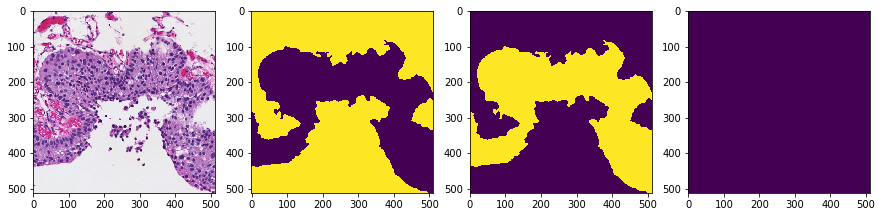

In [17]:
#visualize a single example to verify that it is correct
(img,patch_mask,patch_mask_weight,totals)=dataset["train"][0]
print(totals)
print(np.unique(patch_mask))
fig, ax = plt.subplots(1,4, figsize=(15,4))  # 1 row, 2 columns

#build output showing original patch  (after augmentation), class = 1 mask, weighting mask, overall mask (to see any ignored classes)
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(patch_mask==0)
ax[2].imshow(patch_mask==1)
ax[3].imshow(patch_mask==2)

In [18]:
optim = torch.optim.Adam(model.parameters()) #adam is going to be the most robust, though perhaps not the best performing, typically a good place to start

if use_amp:
    model, optim = amp.initialize(
       model, optim, opt_level="O2", 
       keep_batchnorm_fp32=True, loss_scale="dynamic"
    )
# optim = torch.optim.SGD(model.parameters(),
#                           lr=.1,
#                           momentum=0.9,
#                           weight_decay=0.0005)

In [ ]:
#def trainnetwork():
writer=SummaryWriter() #open the tensorboard visualiser
best_loss_on_test = np.Infinity

start_time = time.time()
for epoch in range(num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: torch.zeros(0).to(device) for key in phases} #keep this on GPU for greatly improved performance
    cmatrix = {key: np.zeros((n_classes,n_classes)) for key in phases}

    for phase in phases: #iterate through both training and validation states

        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        for ii , (X, y, y_weight, totals_layer) in enumerate(dataLoader[phase]): #for each of the batches
            
            totals=np.zeros((2,n_classes)) # we can to keep counts of all the classes in for in particular training, since we 
            totals[0,:]=[0,1]               # can later use this information to create better weights            
            for layer in range(0,totals_layer.shape[0]):
                totals+=totals_layer[layer,:,:].numpy()
                        
            class_weight = totals[1,0:] #don't take ignored class into account here
            class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

            criterion = nn.CrossEntropyLoss(weight = class_weight, ignore_index = ignore_index ,reduce=False) #reduce = False makes sure we get a 2D output instead of a 1D "summary" value
                        
            X = X.to(device)  # [Nbatch, 3, H, W]
            y_weight = y_weight.type('torch.FloatTensor').to(device)
            y = y.type('torch.LongTensor').to(device)  # [Nbatch, H, W] with class indices (0, 1)

            with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                            #disabling is good practice and improves inference time

                prediction = model(X)  # [N, Nclass, H, W]
                loss_matrix = criterion(prediction, y)
                loss = (loss_matrix * (edge_weight**y_weight)).mean() #can skip if edge weight==1

                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    
                    if use_amp:
                        with amp.scale_loss(loss, optim) as scaled_loss:
                            scaled_loss.backward()
                    else:
                        loss.backward()
                        
                    optim.step()
                    train_loss = loss


                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction[:,:,:,:].detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=y.cpu().numpy().flatten()

                    CM = scipy.sparse.coo_matrix((np.ones(yflat.shape[0], dtype=np.int64), (yflat, cpredflat)),
                        shape=(n_classes, n_classes), dtype=np.int64,
                        ).toarray()
                    cmatrix[phase]=cmatrix[phase]+CM

        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

        #save metrics to tensorboard
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        if phase in validation_phases:
            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            writer.add_scalar(f'{phase}/TN', cmatrix[phase][0,0], epoch)
            writer.add_scalar(f'{phase}/TP', cmatrix[phase][1,1], epoch)
            writer.add_scalar(f'{phase}/FP', cmatrix[phase][0,1], epoch)
            writer.add_scalar(f'{phase}/FN', cmatrix[phase][1,0], epoch)
            writer.add_scalar(f'{phase}/TNR', cmatrix[phase][0,0]/(cmatrix[phase][0,0]+cmatrix[phase][0,1]), epoch)
            writer.add_scalar(f'{phase}/TPR', cmatrix[phase][1,1]/(cmatrix[phase][1,1]+cmatrix[phase][1,0]), epoch)

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'n_classes': n_classes,
         'in_channels': in_channels,
         'padding': padding,
         'depth': depth,
         'wf': wf,
         'up_mode': up_mode, 'batch_norm': batch_norm}


        torch.save(state, f"{dataname}_unet_best_model.pth")
    else:
        print("")

/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


0m 57s (- 472m 53s) ([1/500] 0%), train loss: 0.0742 test loss: 0.1843  **
1m 55s (- 478m 18s) ([2/500] 0%), train loss: 0.0608 test loss: 0.1348  **
2m 54s (- 482m 6s) ([3/500] 0%), train loss: 0.0547 test loss: 0.0605  **
3m 54s (- 483m 10s) ([4/500] 0%), train loss: 0.0487 test loss: 0.1087
4m 49s (- 477m 58s) ([5/500] 1%), train loss: 0.0493 test loss: 0.0571  **
5m 46s (- 475m 44s) ([6/500] 1%), train loss: 0.0475 test loss: 0.0763
6m 46s (- 476m 51s) ([7/500] 1%), train loss: 0.0433 test loss: 0.1265
7m 46s (- 477m 33s) ([8/500] 1%), train loss: 0.0474 test loss: 0.0683
8m 45s (- 477m 49s) ([9/500] 1%), train loss: 0.0428 test loss: 0.0523  **
9m 43s (- 476m 9s) ([10/500] 2%), train loss: 0.0426 test loss: 0.0724


In [ ]:
print(totals_layer[0,:,:])
print(totals_layer[layer,:,:])
print(totals+totals_layer[layer,:,:].numpy())

In [ ]:
print(y.shape)

In [ ]:
print(mask)
print(sum(sum(mask==0)))
print(sum(sum(mask==1)))

In [ ]:
print(X[0,0,:,:])

img = np.stack((X[0,0,:,:].cpu(),X[0,1,:,:].cpu(),X[0,2,:,:].cpu()),axis=2)
print(img.shape)
plt.imshow((img*255).astype('uint8'))

In [ ]:
#%load_ext line_profiler
#%lprun -f trainnetwork trainnetwork()

In [ ]:
#At this stage, training is done...below are snippets to help with other tasks: output generation + visualization 

In [ ]:
#----- generate output
#load best model
checkpoint = torch.load(f"{dataname}_unet_best_model.pth")
model.load_state_dict(checkpoint["model_dict"])

In [ ]:
#grab a single image from validation set
(img, label, img_old, totals)=dataset["val"][2]

In [ ]:
#generate its output
#%%timeit
output=model(img[None,::].to(device))
output=output.detach().squeeze().cpu().numpy()
output.shape

In [ ]:
print(output)
print(f"True class:{label}")
print(f"Predicted class:{np.argmax(output)}")

In [ ]:
#look at input
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(img_old)

In [ ]:
#------- visualize kernels and activations

In [ ]:
#helper function for visualization
def plot_kernels(tensor, num_cols=8 ,cmap="gray"):
    if not len(tensor.shape)==4:
        raise Exception("assumes a 4D tensor")
#    if not tensor.shape[1]==3:
#        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0] * tensor.shape[1]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    i=0
    t=tensor.data.numpy()
    for t1 in t:
        for t2 in t1:
            i+=1
            ax1 = fig.add_subplot(num_rows,num_cols,i)
            ax1.imshow(t2 , cmap=cmap)
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [ ]:
class LayerActivations():
    features=None
    def __init__(self,layer):
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self,module,input,output):
        self.features = output.cpu()
    def remove(self):
        self.hook.remove()

In [ ]:
# --- visualize kernels

In [ ]:
w=model.features.denseblock2.denselayer1.conv2
plot_kernels(w.weight.detach().cpu()[0:5,0:5,:,:],5)

In [ ]:
# ---- visualize activiations

In [ ]:
dr=LayerActivations(model.features.denseblock2.denselayer1.conv2)

In [ ]:
(img, label, img_old)=dataset["val"][7]
plt.imshow(np.moveaxis(img.numpy(),0,-1))
output=model(img[None,::].to(device))

In [ ]:
plot_kernels(dr.features,8,cmap="rainbow")

# ---- Improvements:
1 replace Adam with SGD with appropriate learning rate reduction